### 라이브러리 및 데이터 불러오기

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


- Time컬럼을 삭제

In [10]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop("Time",axis = 1 ,inplace = True)
    return df_copy

- 데이터를 train과 test로 분리

In [11]:
def get_train_test_dataset(df=None):
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features,y_target, test_size = 0.3, random_state = 0,stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)


In [12]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


- 예측성능(정확도, 정밀도, 재현율, F1-score, ROC-AUC)을 보여주는 함수

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1:: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

- LogisticRegression을 이용해서 예측

In [14]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차 행렬
[[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1:: 0.7171, AUC: 0.9709


In [15]:
def get_model_train_eval(model,ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train,tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

- LGBM을 이용해서 예측

In [16]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimator = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   38   110]]
정확도: 0.9995, 정밀도: 0.9565, 재현율: 0.7432,    F1:: 0.8365, AUC: 0.9779


### 데이터 분포도 변환 후 모델 학습/예측/평가 
- 좌측으로 치우친 Amount컬럼의 데이터 분포를 변환 및 예측, 평가
- 정규분포 형태로의 변환과 log변환

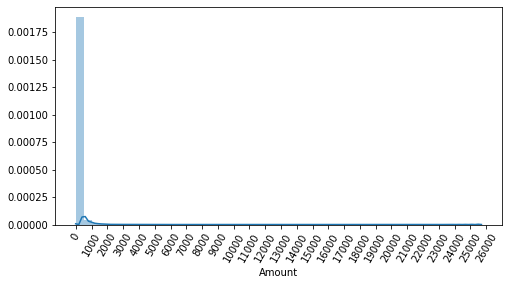

In [17]:
import seaborn as sns

plt.figure(figsize = (8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])
plt.show()

- sklearn의 StandardScaler를 이용하여 정규분포로 바꾸어 줌

In [18]:
# Amount의 분포가 왼쪽으로 치우쳐져 있으니 이를 해결하고자 분포를 정규분포로 바꾸어줌
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    
    # 2차원 array로 들어가야 하기때문에 reshape를 해준다
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 0번째 열에 Amount_Scaled라는 이름의 컬럼을 추가한다 그 값은 amount_n이다
    df_copy.insert(0,'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time','Amount'],axis = 1, inplace = True)
    
    return df_copy
    


In [19]:
def get_train_test_dataset(df=None):
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features,y_target, test_size = 0.3, random_state = 0,stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)


- 분포를 정규분포로 바꾼 후 로지스틱과 LGBM으로 예측

In [21]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("## 로지스틱 회귀 예측 성능 ##")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_test= y_test, tgt_train=y_train)

print("## LGBM 예측 성능 ##")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_test= y_test, tgt_train=y_train)


## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1:: 0.7143, AUC: 0.9707
## LGBM 예측 성능 ##
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1:: 0.8421, AUC: 0.9773


- 이번엔 log변환으로 Amount 컬럼을 변환, 분포가 어느 정도 정규분포에 가깝게 변환

In [22]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    
    # 로그변환 실시(분포가 왼쪽으로 치우친 경우에 사용)
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,"Amount_Scaled",amount_n)
    df_copy.drop(['Time','Amount'],axis = 1, inplace = True)
    return df_copy

In [23]:
def get_train_test_dataset(df=None):
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features,y_target, test_size = 0.3, random_state = 0,stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)


In [24]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8824, 재현율: 0.6081,    F1:: 0.7200, AUC: 0.9721
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1:: 0.8496, AUC: 0.9786


- 결과적으로 정규분포로 변환, 로그변환이 성능에 좋은 영향을 끼쳤으며 로그변환을 했을때 결과가 더 좋게 나옴

### 이상치 데이터 제거 후 모델 학습/예측/평가

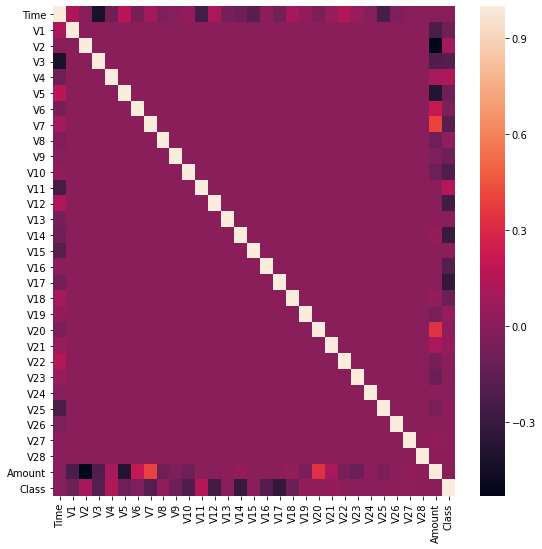

In [25]:
import seaborn as sns

# 상관관계는 거의 없는 것으로 나옴
plt.figure(figsize = (9,9))
corr = card_df.corr()
sns.heatmap(corr)
plt.show()

- 이상치(1/4분위와 3/4분위 지점에 각각 1.5배를 곱하여 각각 이보다 낮거나 높은 수치를 추출)

In [26]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index
    

In [27]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


- V14 컬럼의 이상치를 삭제하는 함수 생성후 적용

In [28]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8829, 재현율: 0.6712,    F1:: 0.7626, AUC: 0.9747
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,    F1:: 0.8930, AUC: 0.9831


- 결과적으로 ROC-AUC기준 성능이 0.005정도 늘어난 것을 확인할 수 있음

### SMOTE 오버샘플링 적용 후 모델 학습/예측/평가

- SMOTE를 이용, 불균형한 데이터셋을 오버샘플링 하여 데이터의 양을 증가시킨후 학습

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print("SMOTE 적용전 학습용 피처/레이블 데이터 세트: ", X_train.shape, y_train.shape)
print("SMOTE 적용후 학습용 피처/레이블 데이터 세트: ", X_train.shape, y_train.shape)
print("SMOTE 적용후 레이블 값 분포: \n", pd.Series(y_train_over).value_counts())


SMOTE 적용전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용후 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용후 레이블 값 분포: 
 1    199020
0    199020
dtype: int64


In [30]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82932  2363]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0540, 재현율: 0.9247,    F1:: 0.1021, AUC: 0.9737


In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    


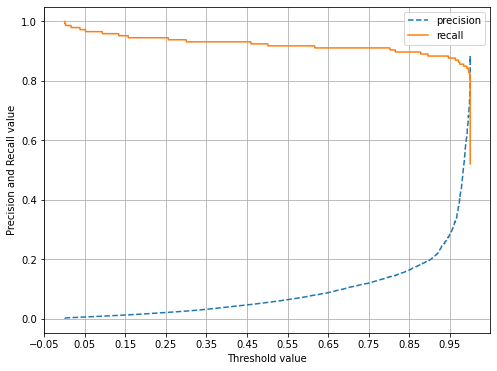

In [32]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [33]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493,    F1:: 0.8889, AUC: 0.9789
